<a href="https://colab.research.google.com/github/awhang/pytorch_fundamentals/blob/main/01_pytorch_workflows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow

Exploring an end-to-end PyTorch workflow

In [159]:
what_is_covered = {1: "data (prepare and load)",
                   2: "build model",
                   3: "fitting the model to data (training)",
                   4: "making predictions and evaluating a model (inference)",
                   5: "saving and loading a model",
                   6: "putting it all together"}

In [160]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks https://pytorch.org/docs/stable/nn.html
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'1.12.1+cu113'

## 1. Data (preparing and loading)

Data can be almost anything in machine learning.

* Excel spreadsheet
* Images
* Video
* Audio
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, we'll create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with known *parameters*.

In [161]:
# Create *known* parameters

weight = 0.7
bias = 0.3

# Create some data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Splitting the data into training and test sets

We'll use our data to create  these training and test sets

In [162]:
# Create a train/test split
# This can also be done with a bit of randomness with utilizing scikit split

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How do we better visualize the data? 
Plot the data.

In [163]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots  training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Plot predictions if available
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show legend
  plt.legend(prop={"size": 14});

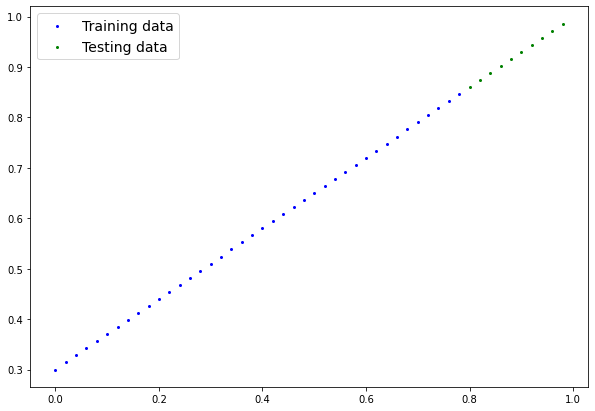

In [164]:
plot_predictions()

## 2. Build model

A very basic PyTorch model.

What the model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to ) the ideal values ( the weight * bias values we used to create the data )

This is done with two algorithms:
1. Gradient descent
2. Backpropagation

In [165]:
from torch import nn

# Create a linear model class
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()

    # Init the model parameters
    self.weights = nn.Parameter(torch.randn(1, # <- starts with a random weight
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, # <- starts with a random bias
                                         requires_grad=True,
                                         dtype=torch.float))
    
    # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias
    

from operator import methodcaller
### PyTorch model building essentials

* torch.nn - contains all the building blocks for computational graphs and neural networks
* torch.nn.Parameter - what parameters the model should try and learn. 
* torch.nn.Module - the base class for all neural network modules, if you subclass it, overwrite the forward() method
** def forward() - All nn.Module subclasses require you to override this. This method defines the forward computation
* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent

PyTorch Cheatsheet: https://pytorch.org/tutorials/beginner/ptcheat.html


### Checking the  contents of our PyTorch model

Now that the model is created, what is inside it?
Let's check the model parameters by using `.parameters()`

In [166]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (a subclass of nn.Module)

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [167]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.

When we pass data through the model it will run it through the forward method.

In [168]:
# Make predictions with the model
with torch.inference_mode(): # inference mode should be used whenever generating predictions to omit these from memory
  y_preds = model_0(X_test)

# torch.no_grad() is similar but inference_mode() is the preferred method
# with torch.no_grad():
#   y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

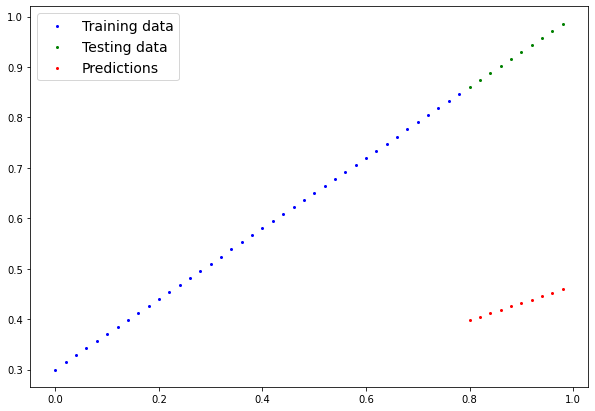

In [169]:
# Plot the predictions against the test values
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters.
Training improves a poor representation to a better representation of data.

One way to measure how poor or wrong the model's predictions are is to use a *loss function*
* Note: Loss functions are also often called cost function or criterion.

Things needed to train a model:
* **Loss function:** A function to measure how wrong the model's predictions are to the ideal outputs. Lower is better.
  - https://pytorch.org/docs/stable/nn.html#loss-functions
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters
  - https://pytorch.org/docs/stable/optim.html

In PyTorch, we need:
- A training loop
- A testing loop

In [170]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.01) # learning rate hyperparameter

### Building the training loop and the testing loop

0. Loop through the data and do the following:
1. Forward pass to make predictions on the data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimize zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of the model with respect to the loss
5. Optimize step - use  the optimizer to adjust the model's parameters to try and improve the loss

In [171]:
torch.manual_seed(42)

# An epoch is one loop through the data
epochs = 500

epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimize the zero grad
  optimizer.zero_grad() # resets the grad

  # 4. Perform back propagation
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval() # turns off gradient tracking and other settings not needed for evaluation/testing
  with torch.inference_mode():
    # 1. Forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the test loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test Loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test Loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test Loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test Loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

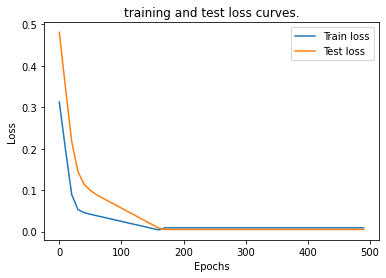

In [172]:
# Plot the loss curves
import numpy as np

plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("training and test loss curves.")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

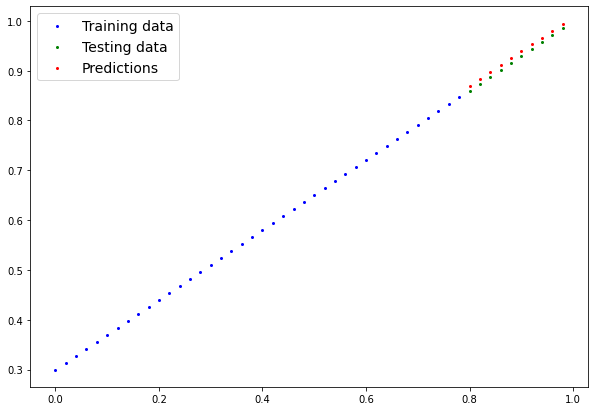

In [175]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)
plot_predictions(predictions=y_preds_new);

In [174]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])